In [1]:
import sys
sys.path.append("/home/paj7rng/mobo_experiments/") 

In [2]:
import torch
torch.set_default_dtype(torch.float64)
import numpy as np
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from gpytorch.mlls import ExactMarginalLogLikelihood

from optimizers.lfbo import LFBO_RFF

## Create objective function via a GP

Two functions are created by using 2 GPs to fit a sine and a cosine function separately (with noise). We use the obtained GP posterior means as our objective functions.

In [3]:
bounds = torch.tensor([[-3.], [3.]])

In [4]:
def sin(x, noise=True):
    if noise:
        return torch.sin(x*2*torch.pi) + torch.rand(x.shape)
    else:
        return torch.sin(x*2*torch.pi)

In [5]:
x_obj = torch.DoubleTensor(30, 1).uniform_(*(bounds.squeeze()))
y_obj = sin(x_obj)
x_dense = torch.linspace(*(bounds.squeeze()), 1000).reshape(-1, 1)

In [6]:
gp_obj = SingleTaskGP(x_obj, y_obj)
mll_obj = ExactMarginalLogLikelihood(gp_obj.likelihood, gp_obj)
fit_gpytorch_mll(mll_obj)
with torch.no_grad():
    gp_obj_posterior = gp_obj.posterior(x_dense)

In [7]:
num_init = 8
x_observed = draw_sobol_samples(bounds=bounds, n=num_init, q=1).squeeze(1)
with torch.no_grad():
    y_observed = gp_obj.posterior(x_observed).mean

### Visualize objective function

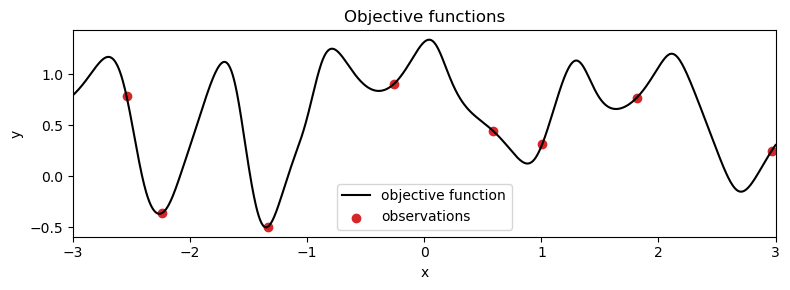

In [8]:
plt.figure(figsize=(8, 3))
ax_func = plt.subplot2grid((1, 1), (0, 0))
ax_func.plot(x_dense, gp_obj_posterior.mean, label="objective function", color='k')
ax_func.scatter(x_observed, y_observed, color='tab:red', label="observations")
ax_func.set_xlabel("x")
ax_func.set_ylabel("y")
ax_func.set_title("Objective functions")
ax_func.set_xlim(*bounds)
ax_func.legend()
plt.tight_layout()

In [9]:
gp = SingleTaskGP(x_observed, y_observed)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)
with torch.no_grad():
    gp_posterior = gp.posterior(x_dense)

In [10]:
# predict
mean_dense = gp_posterior.mean
std_dense = torch.sqrt(gp_posterior.variance)
# standardized std
norm_std = (std_dense - std_dense.min()) / (std_dense.max() - std_dense.min())

# estimate the pareto front
acq_dense = torch.stack([- mean_dense, norm_std]).squeeze().T
pareto = is_non_dominated(acq_dense)

y1_pareto = []
y2_pareto = []
for n, p in enumerate(pareto):
    y1_pareto.append(- mean_dense[n].item() if p else np.nan)
    y2_pareto.append(norm_std[n].item() if p else np.nan)

# get observations
with torch.no_grad():
    observed_posterior = gp.posterior(x_observed)
observed_mean = observed_posterior.mean
observed_std = (torch.sqrt(observed_posterior.variance) - std_dense.min()) / (std_dense.max() - std_dense.min())

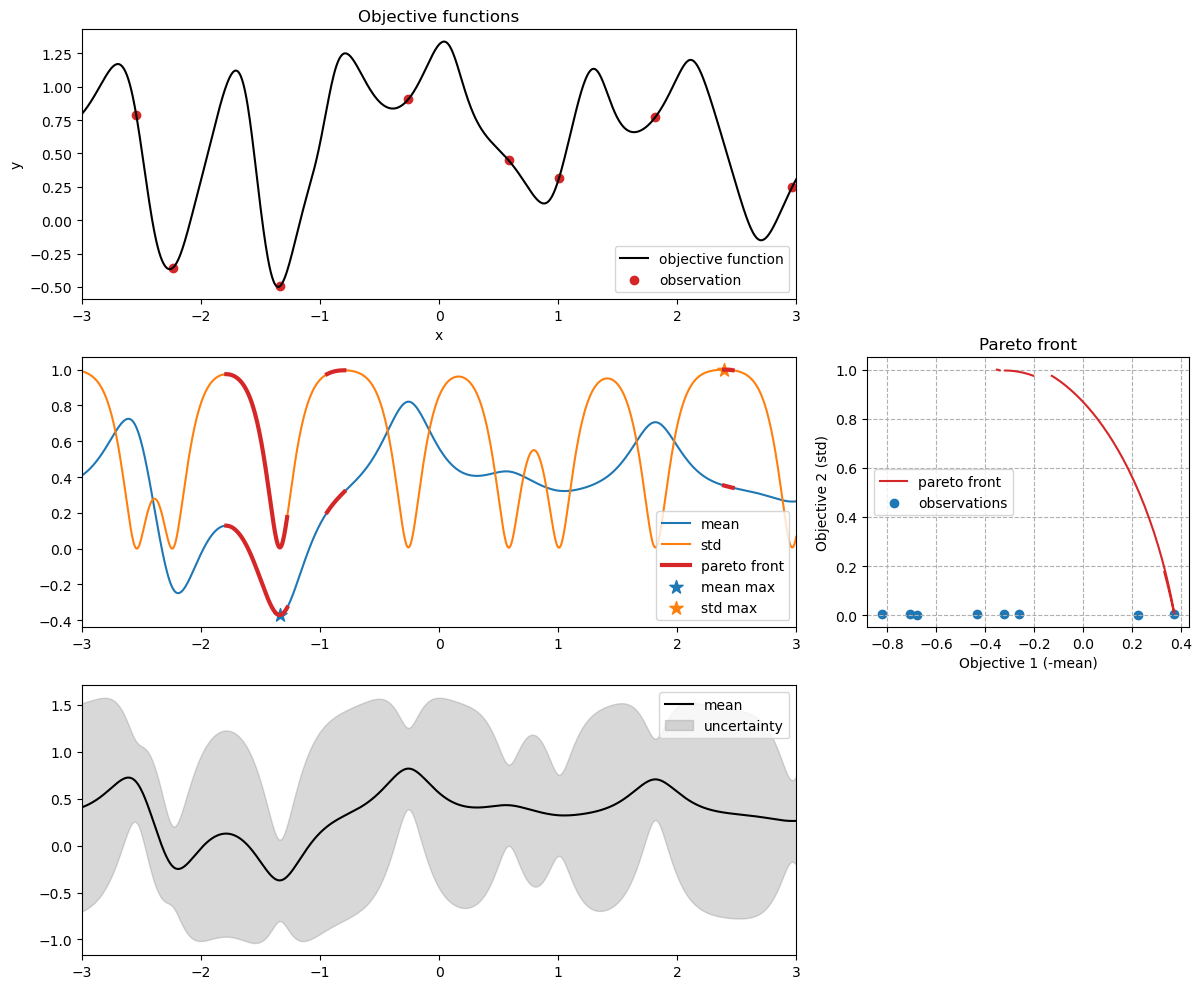

In [11]:
plt.figure(figsize=(12, 10))
ax_func = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax_func.plot(x_dense, gp_obj_posterior.mean, label="objective function", color='k')
ax_func.scatter(x_observed, y_observed, color='tab:red', label='observation')
ax_func.set_xlim(*bounds)
ax_func.set_xlabel("x")
ax_func.set_ylabel("y")
ax_func.set_title("Objective functions")
ax_func.legend()

ax_mo = plt.subplot2grid((3, 3), (1, 0), colspan=2, sharex=ax_func)
ax_mo.plot(x_dense, mean_dense, label="mean")
ax_mo.plot(x_dense, norm_std, label='std')
ax_mo.plot(x_dense, - np.array(y1_pareto), label='pareto front', color='tab:red', linewidth=3)
ax_mo.plot(x_dense, y2_pareto, color='tab:red', linewidth=3)
ax_mo.scatter(x_dense[mean_dense.argmin()], mean_dense.min(), label="mean max", marker='*', color='tab:blue', s=100)
ax_mo.scatter(x_dense[norm_std.argmax()], norm_std.max(), label="std max", marker='*', color='tab:orange', s=100)
ax_mo.legend()

ax_acq = plt.subplot2grid((3, 3), (2, 0), colspan=2, sharex=ax_func)
ax_acq.plot(x_dense, mean_dense, label="mean", color='k')
ax_acq.fill_between(
    x_dense.squeeze(),
    (mean_dense + 2*std_dense).squeeze(),
    (mean_dense - 2*std_dense).squeeze(),
    color='tab:gray',
    alpha=.3,
    label='uncertainty'
)
ax_acq.legend()

ax_pareto = plt.subplot2grid((3, 3), (1, 2), colspan=1)
ax_pareto.plot(y1_pareto, y2_pareto, label='pareto front', color='tab:red')
ax_pareto.scatter(-observed_mean, observed_std, label="observations")
ax_pareto.grid(linestyle='--')
ax_pareto.set_xlabel("Objective 1 (-mean)")
ax_pareto.set_ylabel("Objective 2 (std)")
ax_pareto.set_title("Pareto front")
ax_pareto.legend()

plt.tight_layout()

In [12]:
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.optim.optimize import optimize_acqf_list
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.acquisition.multi_objective.objective import GenericMCMultiOutputObjective, IdentityMCMultiOutputObjective

In [13]:
def initialize_model(x_observed, y_observed):
    models = []
    
    for i in range(y_observed.shape[-1]):
        models.append(
            SingleTaskGP(x_observed, y_observed[:, i][..., None])
        )

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [14]:
q = 4
def optimize_qnehvi(model, x_observed):
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=[-6., -6.],
        X_baseline=x_observed,
        prune_baseline=True,
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=q,
        num_restarts=3,
        raw_samples=4,
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True
    )
    with torch.no_grad():
        posterior = gp.posterior(candidates)
        mean = posterior.mean
        norm_std = (torch.sqrt(posterior.variance) - std_dense.min()) / (std_dense.max() - std_dense.min())

    new_obj = torch.stack([-mean, norm_std]).squeeze().T
    return candidates, new_obj

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

def plot_mobo_obs(x_observed, y_observed, num_init, num_iterations):
    fig = plt.figure(figsize=(12, 4))

    num_batch = len(x_observed) / q
    batch_num = np.repeat(np.arange(num_batch), q)

    ax_func = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax_func.plot(x_dense, mean_dense, label="objective 1 (mean)")
    ax_func.plot(x_dense, norm_std, label="objective 2 (std)")
    ax_func.plot(x_dense, -np.array(y1_pareto), color='tab:red', linewidth=3, label="pareto front")
    ax_func.plot(x_dense, y2_pareto, color='tab:red', linewidth=3)
    ax_func.scatter(x_observed, -y_observed[:, 0].reshape(x_observed.shape), c=batch_num)
#     ax_func.scatter(x_observed, y_observed[:, 1].reshape(x_observed.shape), c=batch_num)
    ax_func.set_xlabel("x")
    ax_func.set_ylabel("y")
    ax_func.set_title("Objective functions")
#     ax_func.legend()

    ax_pareto = plt.subplot2grid((1, 3), (0, 2), colspan=1)
    ax_pareto.plot(y1_pareto, y2_pareto, label='pareto front', color='tab:red')
    ax_pareto.scatter(*y_observed.T, label="observations", c=batch_num)
    
    pareto = is_non_dominated(y_observed)
    sort_idx = np.argsort(y_observed[pareto][:, 0])
    plt.plot(*y_observed[pareto][sort_idx].T, label='approximated pareto front', color='tab:pink')
    
    ax_pareto.grid(linestyle='--')
    ax_pareto.set_xlabel("Objective 1")
    ax_pareto.set_ylabel("Objective 2")
    ax_pareto.set_title("Pareto front")
#     ax_pareto.legend()
    
    norm = plt.Normalize(0, num_iterations + num_init)
    sm =  ScalarMappable(norm=norm, cmap=cm)
    divider = make_axes_locatable(ax_pareto)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.set_title("Iteration")

    plt.tight_layout()
    plt.show()

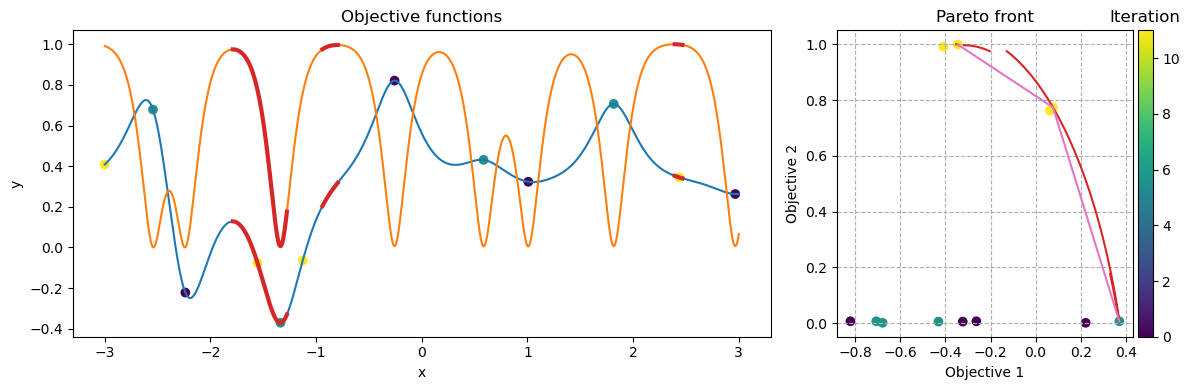

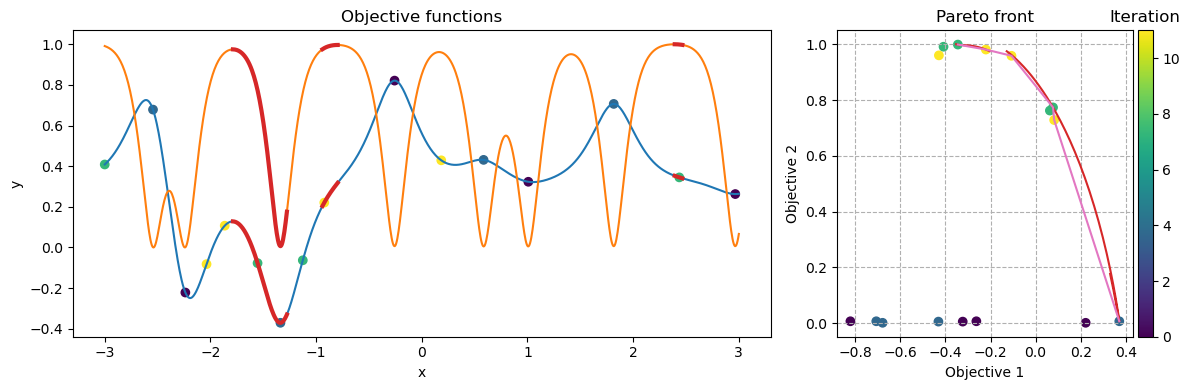

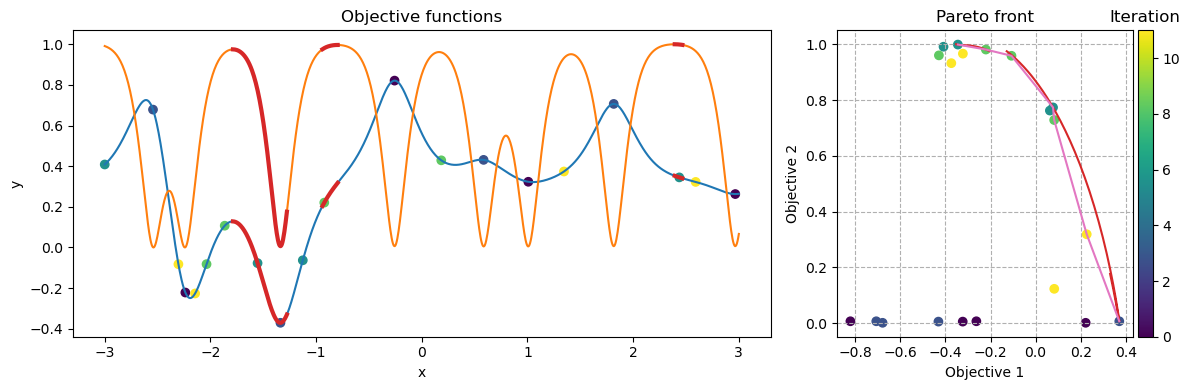

In [16]:
num_iterations = 3
x_acq_observed = x_observed
acq_observed = torch.stack([-observed_mean, observed_std]).squeeze().T

ref_point = torch.tensor([-6., -6.])
hvs_qnehvi = []

mll_qnehvi, model_qnehvi = initialize_model(x_acq_observed, acq_observed)
bd = DominatedPartitioning(ref_point=ref_point, Y=acq_observed)
volume = bd.compute_hypervolume().item()
hvs_qnehvi.append(volume)

for iterations in range(num_iterations):
    fit_gpytorch_mll(mll_qnehvi)
    new_x_qnehvi, new_obj_qnehvi = optimize_qnehvi(model_qnehvi, x_acq_observed)
    x_acq_observed = torch.cat([x_acq_observed, new_x_qnehvi])
    acq_observed = torch.cat([acq_observed, new_obj_qnehvi])

    bd = DominatedPartitioning(ref_point=ref_point, Y=-acq_observed)
    volume = bd.compute_hypervolume().item()
    hvs_qnehvi.append(volume)

#     if iterations % 5 == 0:
    plot_mobo_obs(x_acq_observed, acq_observed, num_init, num_iterations)

In [17]:
pareto = is_non_dominated(acq_observed)
x_cand = x_acq_observed[pareto]
with torch.no_grad():
    posterior_cand = gp.posterior(x_cand)
mean_cand = posterior_cand.mean
std_cand = (torch.sqrt(posterior_cand.variance) - std_dense.min()) / (std_dense.max() - std_dense.min())

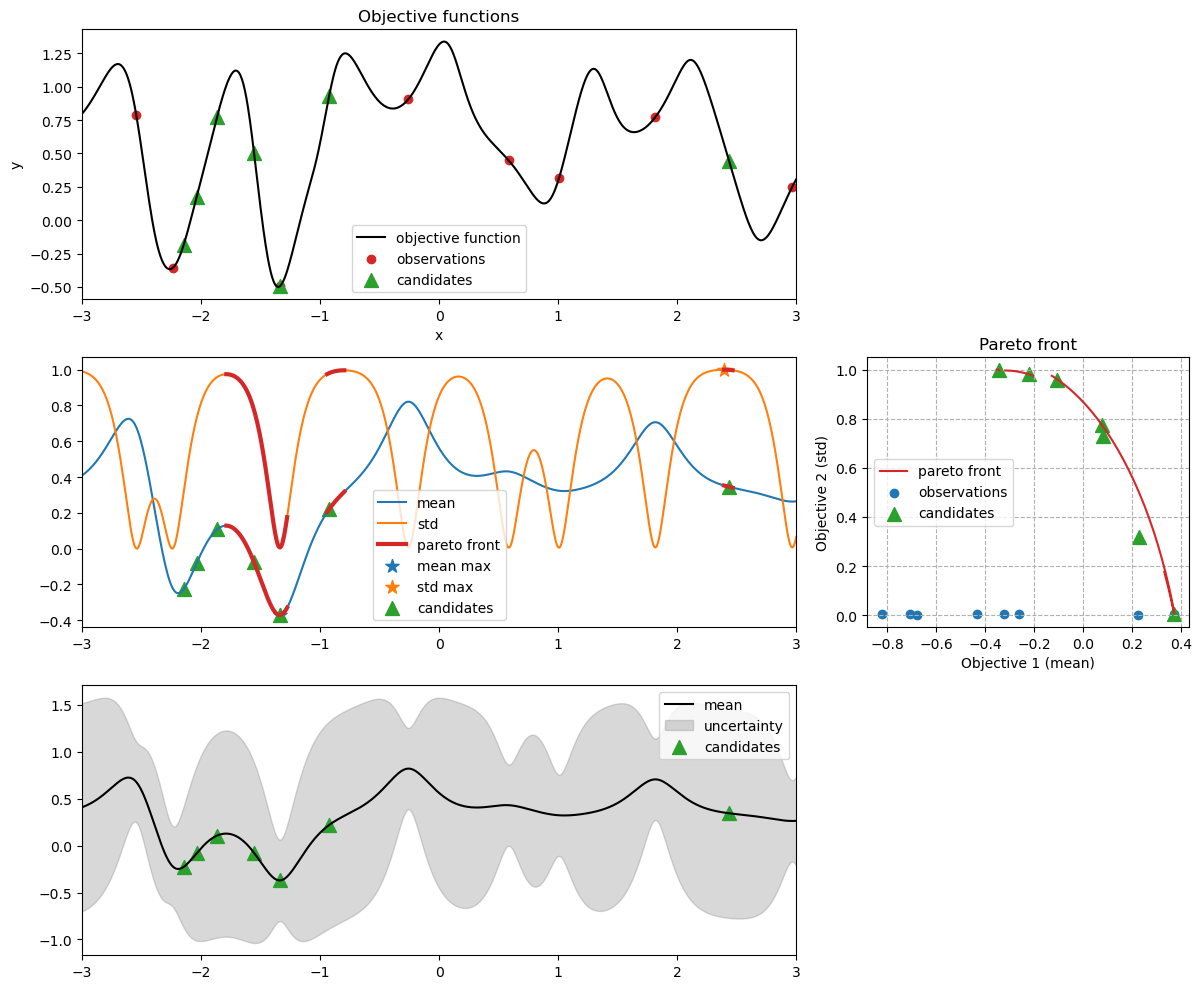

In [18]:
plt.figure(figsize=(12, 10))
ax_func = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax_func.plot(x_dense, gp_obj_posterior.mean, label="objective function", color='k')
ax_func.scatter(x_observed, y_observed, color='tab:red', label="observations")
with torch.no_grad():
    ax_func.scatter(x_cand, gp_obj.posterior(x_cand).mean, label="candidates", marker='^', color='tab:green', s=100)
ax_func.set_xlim(*bounds)
ax_func.set_xlabel("x")
ax_func.set_ylabel("y")
ax_func.set_title("Objective functions")
ax_func.legend()

ax_mo = plt.subplot2grid((3, 3), (1, 0), colspan=2, sharex=ax_func)
ax_mo.plot(x_dense, mean_dense, label="mean")
ax_mo.plot(x_dense, norm_std, label='std')
ax_mo.plot(x_dense, - np.array(y1_pareto), label='pareto front', color='tab:red', linewidth=3)
ax_mo.plot(x_dense, y2_pareto, color='tab:red', linewidth=3)
ax_mo.scatter(x_dense[mean_dense.argmin()], mean_dense.min(), label="mean max", marker='*', color='tab:blue', s=100)
ax_mo.scatter(x_dense[norm_std.argmax()], norm_std.max(), label="std max", marker='*', color='tab:orange', s=100)
ax_mo.scatter(x_cand, mean_cand, label="candidates", marker='^', color='tab:green', s=100)
ax_mo.legend()

ax_acq = plt.subplot2grid((3, 3), (2, 0), colspan=2, sharex=ax_func)
ax_acq.plot(x_dense, mean_dense, label="mean", color='k')
ax_acq.fill_between(
    x_dense.squeeze(),
    (mean_dense + 2*std_dense).squeeze(),
    (mean_dense - 2*std_dense).squeeze(),
    color='tab:gray',
    alpha=.3,
    label='uncertainty'
)
ax_acq.scatter(x_cand, mean_cand, label="candidates", marker='^', color='tab:green', s=100)
ax_acq.legend()

ax_pareto = plt.subplot2grid((3, 3), (1, 2), colspan=1)
ax_pareto.plot(y1_pareto, y2_pareto, label='pareto front', color='tab:red')
ax_pareto.scatter(- observed_mean, observed_std, label="observations")
ax_pareto.scatter(- mean_cand, std_cand, label="candidates", marker='^', color='tab:green', s=100)
ax_pareto.grid(linestyle='--')
ax_pareto.set_xlabel("Objective 1 (mean)")
ax_pareto.set_ylabel("Objective 2 (std)")
ax_pareto.set_title("Pareto front")
ax_pareto.legend()

plt.tight_layout()